# Capstone Notebook 3: Predicting Made Shots With Machine Learning

# Introduction
- We have already done an in-depth analysis of shooting and defensive statistics.
- We also created a model for predicting the outcome of a game.
- Here we will develop models for predicting the outcome of a shot, made or missed.
- Since we have data related to shots we hope to improve on our previous win or loss predictions.
- From our previous analysis we know the overall league average for shots made is 45%.
- We will attempt to build a model that improves on this ground truth average of 45%
- Even if we find a model with predictive value of 60% or higher, this still provides important information.
- The model along with the most important features can provide important information to teams regarding the factors and scenarios most likely to result in a made shot.


# 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import warnings
np.random.seed(10)
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("darkgrid")

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# 1.2 EDA

#### IMPORT DATA FROM CSV FILE

In [2]:
# Read the SHOT LOGS data into a Pandas DataFrame
df = pd.read_csv('shot_logs.csv')

In [3]:
# Visualize the head of the data frame
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


#### TOUCH_TIME HAS NEG VALUES. DOESNT MAKE SENSE REPLACE WITH POSITIVE VALUES

In [4]:
df.TOUCH_TIME = df.TOUCH_TIME.abs()

#### CONVERT HOME_GAME TO ('H'=1, 'A'=0).  CONVERT GAME_WON TO ('W'=1, 'L'=0)

In [5]:
df['HOME_GAME'] = np.where(df['LOCATION'] == 'H', 1, 0)
df['GAME_WON'] = np.where(df['W'] == 'W', 1, 0)

#### WE ARE ONLY INTERESTED IN THE MUMERICAL VALUES VIEW WITH DESCRIBE METHOD

In [6]:
df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,HOME_GAME,GAME_WON
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.778013,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247,0.499215,0.504377
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.032631,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336,0.500001,0.499983
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000,0.000000,0.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000,0.000000,0.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000,0.000000,1.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000,1.000000,1.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,163.600000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000,1.000000,1.000000


In [7]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,HOME_GAME,GAME_WON
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,0,1
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,0,1
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,0,1
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,0,1
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,0,1


#### REPLACE MISSING SHOT_CLOCK VALUES WITH MEAN (THESE ARE THE ONLY MISSING VALUES)

In [8]:
df = df.fillna(df.SHOT_CLOCK.mean())

In [9]:
# check for null values
df.isnull().sum()

GAME_ID                       0
MATCHUP                       0
LOCATION                      0
W                             0
FINAL_MARGIN                  0
SHOT_NUMBER                   0
PERIOD                        0
GAME_CLOCK                    0
SHOT_CLOCK                    0
DRIBBLES                      0
TOUCH_TIME                    0
SHOT_DIST                     0
PTS_TYPE                      0
SHOT_RESULT                   0
CLOSEST_DEFENDER              0
CLOSEST_DEFENDER_PLAYER_ID    0
CLOSE_DEF_DIST                0
FGM                           0
PTS                           0
player_name                   0
player_id                     0
HOME_GAME                     0
GAME_WON                      0
dtype: int64

#### CREATE DATAFRAME FOR MODELING WITH ONLY RELEVANT NUMERICAL FEATURES AND FGM TARGET

In [10]:
data = df[['FINAL_MARGIN','SHOT_NUMBER','PERIOD','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST','HOME_GAME','GAME_WON','FGM']]

In [11]:
data.head()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,HOME_GAME,GAME_WON,FGM
0,24,1,1,10.800000,2,1.9,7.7,2,1.3,0,1,1
1,24,2,1,3.400000,0,0.8,28.2,3,6.1,0,1,0
2,24,3,1,12.453344,3,2.7,10.1,2,0.9,0,1,0
3,24,4,2,10.300000,2,1.9,17.2,2,3.4,0,1,0
4,24,5,2,10.900000,2,2.7,3.7,2,1.1,0,1,0


#### WE KNOW FROM PREVIOUS ANALYSIS THERE IS A 20% TARGET CLASS IMBALANCE. ADDRESS WITH SMOTE

In [12]:
df_a = data
df_a.shape

(128069, 12)

In [13]:
#Prepare the Data for SMOTE
X_a = df_a.drop(['FGM'], axis=1)
y_a = df_a.FGM
print(X_a.shape, y_a.shape)

(128069, 11) (128069,)


In [14]:
# Value Counts to inspect the Imbalance
y_a.value_counts()

0    70164
1    57905
Name: FGM, dtype: int64

In [15]:
# SMOTE resampling
X_resampled, y_resampled = SMOTE(random_state=10).fit_sample(X_a, y_a)

In [16]:
# Return the features and target back into a Pandas DataFrames
df_X = pd.DataFrame(X_resampled, columns=X_a.columns)
df_y = pd.DataFrame(y_resampled, columns=['FGM'])

In [17]:
data = pd.concat([df_X, df_y], axis=1)
data.head(2)

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,HOME_GAME,GAME_WON,FGM
0,24.0,1.0,1.0,10.8,2.0,1.9,7.7,2.0,1.3,0.0,1.0,1
1,24.0,2.0,1.0,3.4,0.0,0.8,28.2,3.0,6.1,0.0,1.0,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140328 entries, 0 to 140327
Data columns (total 12 columns):
FINAL_MARGIN      140328 non-null float64
SHOT_NUMBER       140328 non-null float64
PERIOD            140328 non-null float64
SHOT_CLOCK        140328 non-null float64
DRIBBLES          140328 non-null float64
TOUCH_TIME        140328 non-null float64
SHOT_DIST         140328 non-null float64
PTS_TYPE          140328 non-null float64
CLOSE_DEF_DIST    140328 non-null float64
HOME_GAME         140328 non-null float64
GAME_WON          140328 non-null float64
FGM               140328 non-null int64
dtypes: float64(11), int64(1)
memory usage: 12.8 MB


In [19]:
data.isnull().sum()

FINAL_MARGIN      0
SHOT_NUMBER       0
PERIOD            0
SHOT_CLOCK        0
DRIBBLES          0
TOUCH_TIME        0
SHOT_DIST         0
PTS_TYPE          0
CLOSE_DEF_DIST    0
HOME_GAME         0
GAME_WON          0
FGM               0
dtype: int64

#### CREATE FEATURES AND TARGET

In [20]:
features = data.drop(['FGM'], axis=1)
target = data.FGM
target.shape, features.shape

((140328,), (140328, 11))

#### INSPECT THE BALANCE OF THE TARGET CLASS

In [21]:
target.value_counts()

1    70164
0    70164
Name: FGM, dtype: int64

#### VISUALIZE THE DISTRIBUTIONS OF THE FEATURES

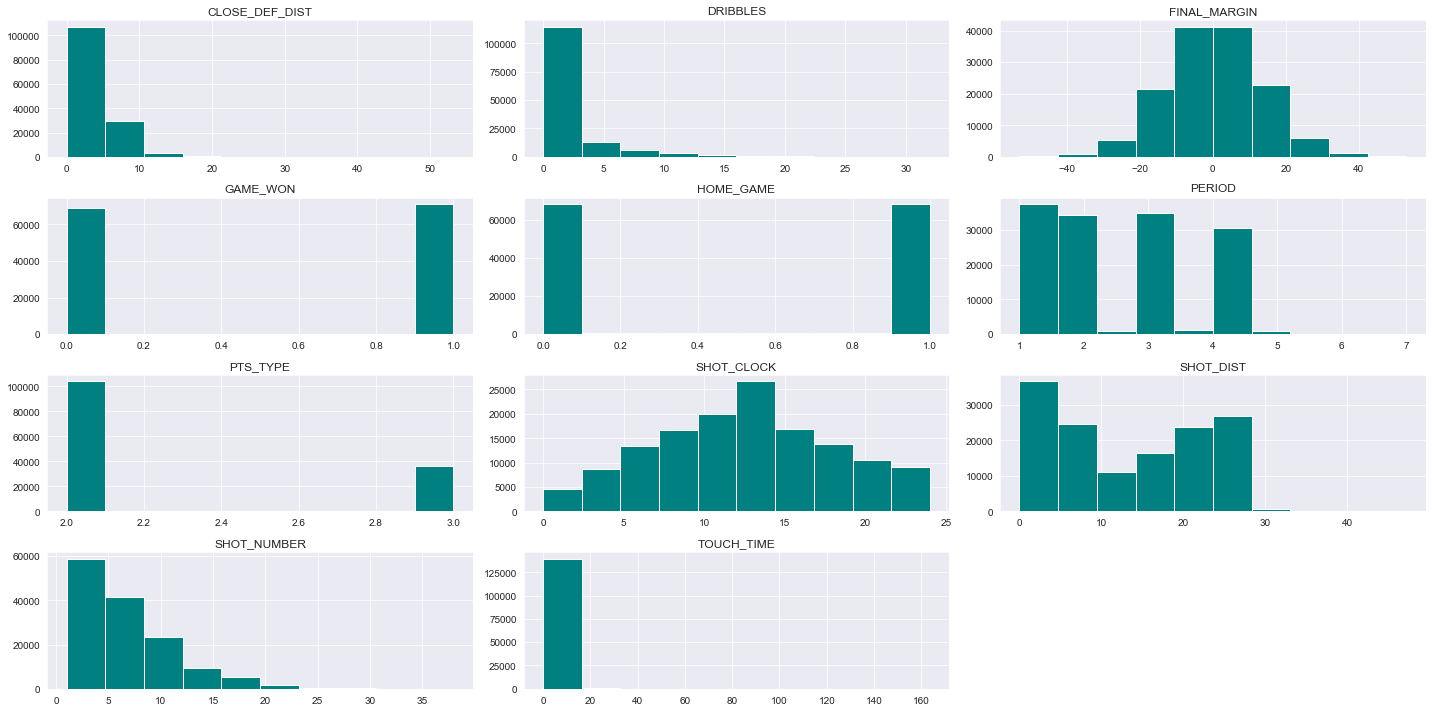

In [22]:
# Visualize features
features.hist(figsize=(20,10), color="teal")
plt.tight_layout()
plt.show()

#### VISUALIZE THE CORRELATION BETWEEN FEATURES AND TARGET

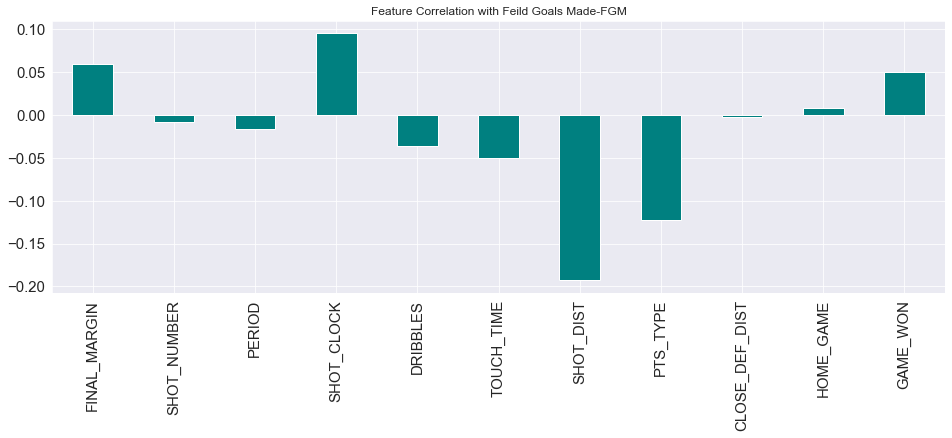

In [23]:
# Investigate the correlation between Target class and features
features.corrwith(target).plot.bar(
        figsize = (16, 5), color='teal', title = "Feature Correlation with Feild Goals Made-FGM", fontsize = 15,
        rot = 90, grid = True)
plt.show()

#### FEATURE ENGINEERING COMBINE BEST FEATURES BASED ON POITIVE OR NEGATIVE CORRELATION

In [24]:
data2 = data.copy()

In [25]:
# create new colums for engineered features
data2['A'] = data2.SHOT_DIST + data2.PTS_TYPE
data2['B'] = data2.TOUCH_TIME + data2.DRIBBLES + data2.PERIOD + data2.SHOT_NUMBER
data2['C'] = data2.SHOT_CLOCK + data2.FINAL_MARGIN
data2['D'] = data2.HOME_GAME + data2.CLOSE_DEF_DIST + data2.GAME_WON

In [26]:
# Define features and Target for engineered features
features2 = data2[['A', 'B', 'C', 'D']]
target2 = data2['FGM']
target2.shape, features2.shape

((140328,), (140328, 4))

#### INSPECT THE CORRELATION BETWEEN ENGINEERED FEATURES AND TARGET

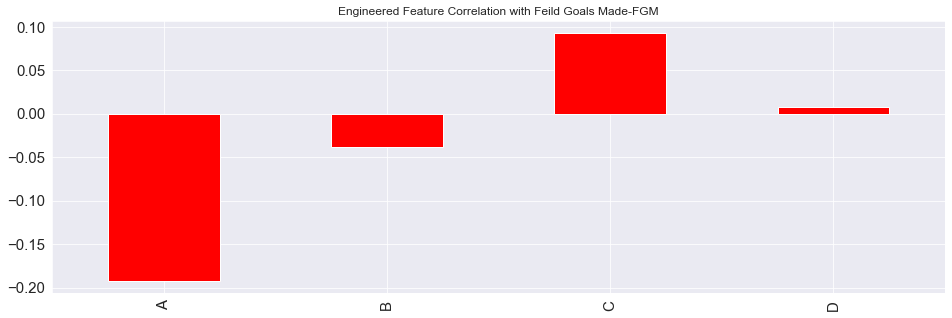

In [27]:
# Investigate the correlation between Target class and  Engineered features
features2.corrwith(target2).plot.bar(
        figsize = (16, 5), color='r', title = "Engineered Feature Correlation with Feild Goals Made-FGM", fontsize = 15,
        rot = 90, grid = True)
plt.show()

#### VISUALIZE HOW FEATURES DIFFER BETWEEN TARGET CLASS

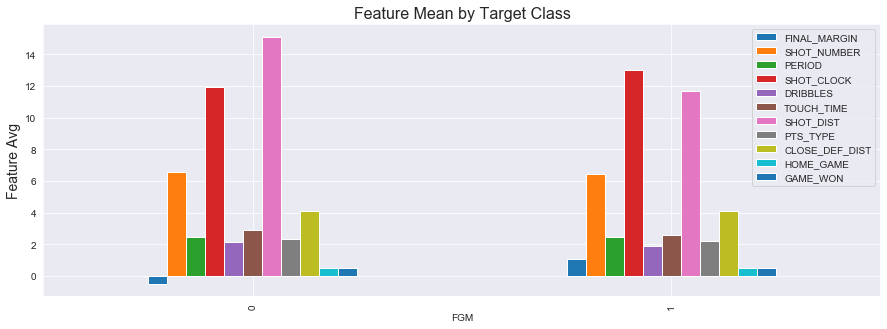

In [28]:
topfeatures = features.columns
data.groupby('FGM')[topfeatures].mean().plot.bar(figsize=(15,5))
plt.legend(loc='upper right',fontsize=10)
plt.title('Feature Mean by Target Class', fontsize=16)
plt.ylabel('Feature Avg', fontsize=14)
plt.show()

#### VISUALIZE HOW ENGINEERED FEATURES DIFFER BETWEEN TARGET CLASS

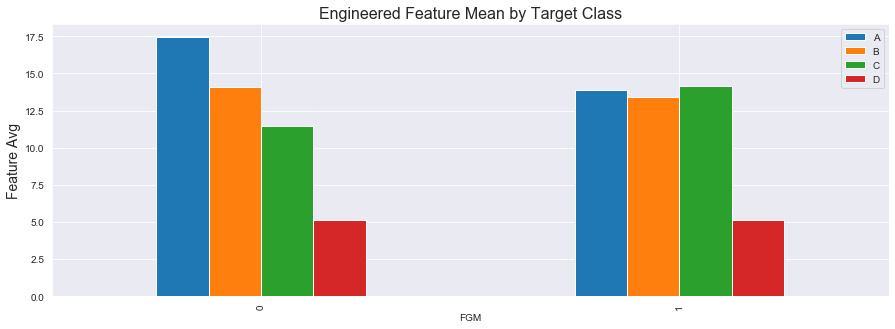

In [29]:
topfeatures = features2.columns
data2.groupby('FGM')[topfeatures].mean().plot.bar(figsize=(15,5))
plt.legend(loc='best')
plt.title('Engineered Feature Mean by Target Class', fontsize=16)
plt.ylabel('Feature Avg', fontsize=14)
plt.show()

# 2.1 Modeling

#### 75/25 TRAIN TEST SPLIT ALL FEATURES

In [30]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=10)

#### 75/25 TRAIN TEST SPLIT ENGINEERED FEATURES

In [31]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(features2, target2, test_size=0.25, random_state=10)

# 2.2 Baseline Random Forest Model All Features

In [32]:
# Set up and fit the intital Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=10)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [33]:
# get predicted values
rf_pred = rf_clf.predict(x_test)

#### CLASSIFICATION REPORT FOR BASELINE RF MODEL ALL FEATURES

In [34]:
print(60*'-')
print('Random Forest Baseline Model All Features')
print(60*'-')
report_rf = classification_report(y_test, rf_pred)
print(report_rf)
print(60*'-')

------------------------------------------------------------
Random Forest Baseline Model All Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.73      0.66     17526
           1       0.65      0.51      0.57     17556

    accuracy                           0.62     35082
   macro avg       0.63      0.62      0.62     35082
weighted avg       0.63      0.62      0.62     35082

------------------------------------------------------------


#### CONFUSION MATRIX FOR BASELINE RF MODEL ALL FEATURES

In [35]:
def conf_matrix(y_actual, y_predicted, cmap='Blues'):
    class_names = ['Missed', 'Made']
    mat = confusion_matrix(y_actual, y_predicted)
    dataframe = pd.DataFrame(mat, index=class_names, columns=class_names)
    plt.figure(figsize=(10,5))
    sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap, fmt='.00f', annot_kws={"size":13})
    plt.title("Confusion Matrix", fontsize=18), plt.tight_layout()
    plt.ylabel("True Class",fontsize=15), plt.xlabel('Predicted Class', fontsize=15)
    plt.show()

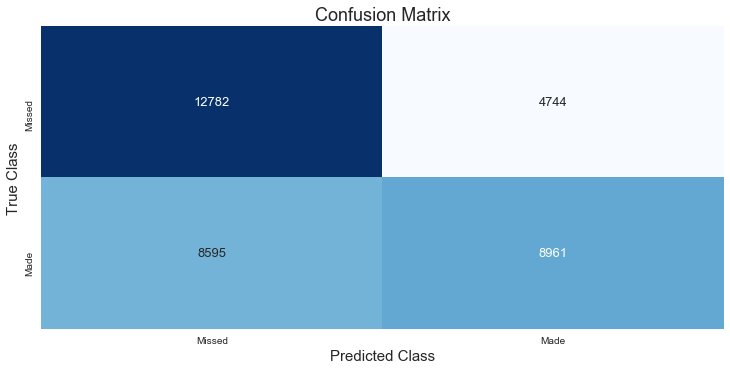

In [36]:
conf_matrix(y_test, rf_pred)

#### TRAIN AND TEST SCORES FOR BASELINE RF MODEL ALL FEATURES

In [37]:
# Train and Test Scores For Baseline rf Model all features
print("BASELINE RF MODEL ALL FEATURES FINAL TRAIN SCORES: {}".format(rf_clf.score(x_train, y_train)))
print("BASELINE RF MODEL ALL FEATURES FINAL TEST SCORES: {}".format(rf_clf.score(x_test, y_test)))

BASELINE RF MODEL ALL FEATURES FINAL TRAIN SCORES: 0.9840278965471372
BASELINE RF MODEL ALL FEATURES FINAL TEST SCORES: 0.6197765235733425


#### CALCULATE 10-FOLD CV SCORES BASELINE RF MODEL ALL FEATURES

In [38]:
# 10 fold Cross-validation Accuracy
#rf_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#rf_cv_results_a = cross_val_score(rf_clf, features, target, cv=rf_kf, scoring="accuracy",n_jobs=-1) 
#rf_cv_results_p = cross_val_score(rf_clf, features, target, cv=rf_kf, scoring="precision_weighted",n_jobs=-1)
#rf_cv_results_r = cross_val_score(rf_clf, features, target, cv=rf_kf, scoring="recall_weighted",n_jobs=-1)
#rf_cv_results_f = cross_val_score(rf_clf, features, target, cv=rf_kf, scoring="f1_weighted",n_jobs=-1)

In [39]:
rf_cv_a = [0.61847075, 0.62124991, 0.62894606, 0.62374403, 0.62003848,0.62410033, 0.61968218, 0.62338773, 0.61438141, 0.62179304]

In [40]:
rf_cv_p = [0.62480748, 0.62824405, 0.63357711, 0.62996477, 0.62711839,0.62953059, 0.62449295, 0.62853784, 0.62061683, 0.62712598]

In [41]:
rf_cv_r = [0.61847075, 0.62124991, 0.62894606, 0.62374403, 0.62003848,0.62410033, 0.61968218, 0.62338773, 0.61438141, 0.62179304]

In [42]:
rf_cv_f = [0.61421792, 0.61651218, 0.62468998, 0.61928075, 0.6152871 ,0.61976412, 0.61588332, 0.61970266, 0.60973242, 0.61711576]

# 2.3 Random Forest Model with Engineered Features

In [43]:
# Set up and fit the intital Random Forest Classifier with 4 engineered features
rf_clf2 = RandomForestClassifier(random_state=10)
rf_clf2.fit(x_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [44]:
# get predicted values
rf_pred2 = rf_clf2.predict(x_test1)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX RF MODEL ENGINEERED FEATURES

In [45]:
print(60*'-')
print('Random Forest Baseline Model All Features')
print(60*'-')
report_rf2 = classification_report(y_test1, rf_pred2)
print(report_rf2)
print(60*'-')

------------------------------------------------------------
Random Forest Baseline Model All Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.68      0.62     17526
           1       0.60      0.49      0.54     17556

    accuracy                           0.58     35082
   macro avg       0.59      0.58      0.58     35082
weighted avg       0.59      0.58      0.58     35082

------------------------------------------------------------


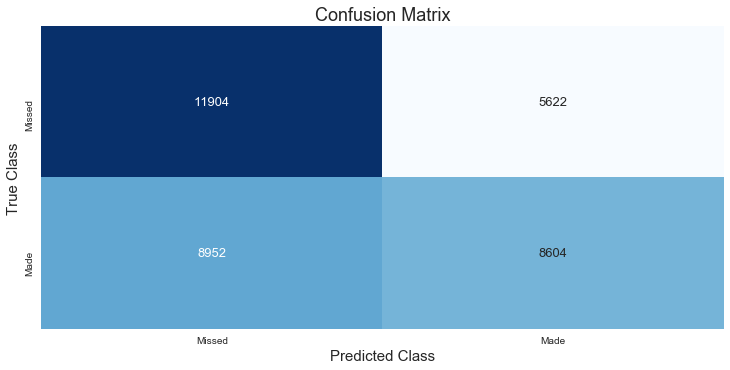

In [46]:
conf_matrix(y_test1, rf_pred2)

#### TRAIN AND TEST SCORES FOR BASELINE RF MODEL ENGINEERED FEATURES

In [47]:
# Train and Test Scores For rf Model Engineered features
print("RF MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: {}".format(rf_clf2.score(x_train1, y_train1)))
print("RF MODEL ENGINEERED FEATURES FINAL TEST SCORES: {}".format(rf_clf2.score(x_test1, y_test1)))

RF MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: 0.9817095186515402
RF MODEL ENGINEERED FEATURES FINAL TEST SCORES: 0.5845732854455277


#### 10 FOLD-CV RF MODEL ENGINEERED FEATURES

In [48]:
# 10 fold Cross-validation Accuracy
#rf2_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#rf2_cv_results_a = cross_val_score(rf_clf2, features2, target2, cv=rf2_kf, scoring="accuracy",n_jobs=-1) 
#rf2_cv_results_p = cross_val_score(rf_clf2, features2, target2, cv=rf2_kf, scoring="precision_weighted",n_jobs=-1)
#rf2_cv_results_r = cross_val_score(rf_clf2, features2, target2, cv=rf2_kf, scoring="recall_weighted",n_jobs=-1)
#rf2_cv_results_f = cross_val_score(rf_clf2, features2, target2, cv=rf2_kf, scoring="f1_weighted",n_jobs=-1)

In [49]:
rf2_cv_a = [0.59082163, 0.58868382, 0.59167676, 0.58946768, 0.59117794,0.58754365, 0.58048885, 0.58469322, 0.58687286, 0.58366591]

In [50]:
rf2_cv_p = [0.59481015, 0.59252232, 0.59378264, 0.59247414, 0.59453574,0.59062393, 0.5829755 , 0.58708232, 0.58973249, 0.58562587]

In [51]:
rf2_cv_r = [0.59082163, 0.58868382, 0.59167676, 0.58946768, 0.59117794,0.58754365, 0.58048885, 0.58469322, 0.58687286, 0.58366591]

In [52]:
rf2_cv_f = [0.58724989, 0.58497361, 0.5880823 , 0.58621368, 0.58816355, 0.5835306 , 0.57720073, 0.58198079, 0.58397276, 0.5804764 ]

#### LOOK AT FEATURE IMPORTANCES FOR OUR FIRST TWO MODELS

In [53]:
# Function to visually inspect feature importances
def plot_feat_imp(model_classifier, data=features, color='r'):
    importances1 = model_classifier.feature_importances_
    features1 = data.columns
    features_importance1 = pd.DataFrame(importances1, index=features1, columns=['Importance'])
    sorted_feat_imp1 = features_importance1.sort_values('Importance', axis=0, ascending=False)
    plt.figure(figsize=(12,5))
    plt.title('Feature Importance in Model', fontsize=18)
    tmp = sorted_feat_imp1['Importance'].values.tolist()
    plt.bar(range(data.shape[1]), tmp, color=color )
    plt.xticks(range(data.shape[1]), sorted_feat_imp1.index, rotation=45, ha='center', fontsize=12)
    plt.xlim(-1, data.shape[1])
    plt.ylabel('Importance', fontsize=15)
    plt.tight_layout()
    plt.show()

#### FEATURE IMPORTANCE BASELINE RF MODEL ALL FEATURES

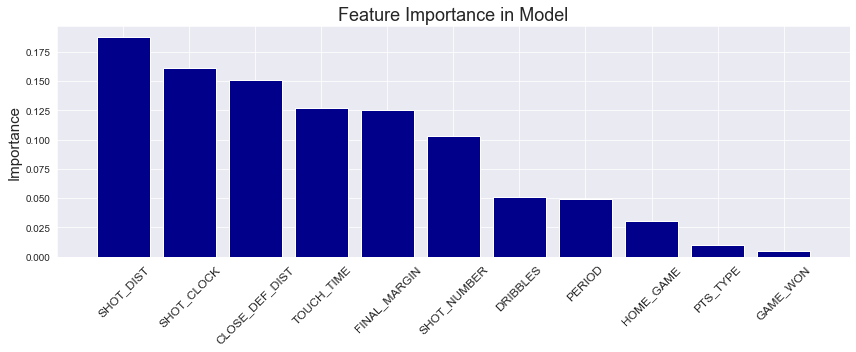

In [54]:
plot_feat_imp(rf_clf, data=features, color='darkblue')

#### FEATURE IMPORTANCE RF MODEL ENGINEERED FEATURES

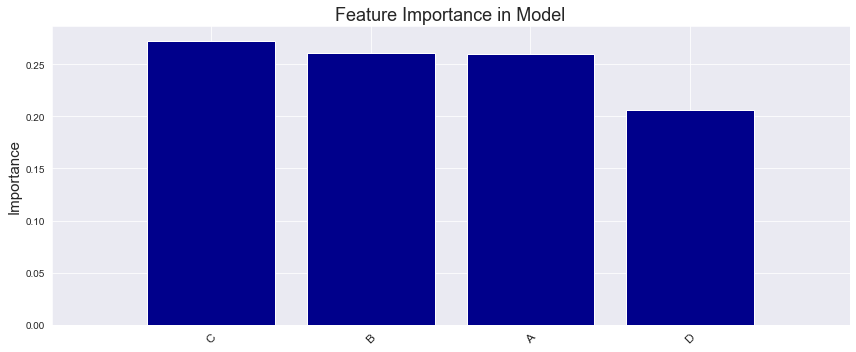

In [55]:
plot_feat_imp(rf_clf2, data=features2, color='darkblue')

# 2.4 AdaBoost Classifier All Features

#### SET UP ADABOOST CLASSIFIER FOR ALL FEATURES

In [56]:
ab_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=10)
ab_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=10)

In [57]:
ab_pred = ab_clf.predict(x_test)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX FOR ADABOOST MODEL ALL FEATURES

In [58]:
print(60*'-')
print('AB Baseline Model All Features')
print(60*'-')
report_ab = classification_report(y_test, ab_pred)
print(report_ab)
print(60*'-')

------------------------------------------------------------
AB Baseline Model All Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.71      0.65     17526
           1       0.65      0.54      0.59     17556

    accuracy                           0.63     35082
   macro avg       0.63      0.63      0.62     35082
weighted avg       0.63      0.63      0.62     35082

------------------------------------------------------------


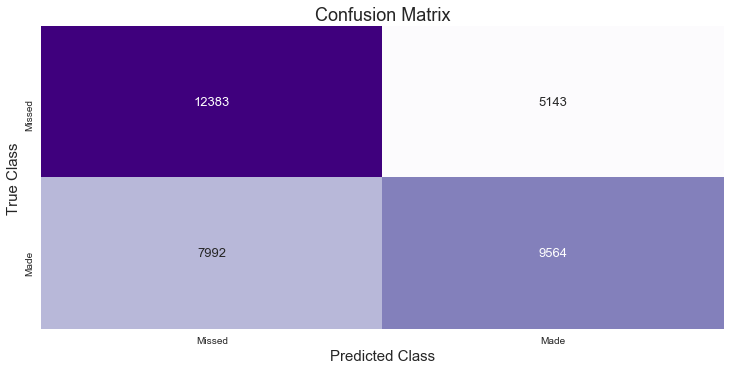

In [59]:
conf_matrix(y_test, ab_pred, cmap="Purples")

#### TRAIN AND TEST SCORES FOR ADABOOST MODEL ALL FEATURES

In [60]:
# Train and Test Scores For Baseline AB Model all features
print("ADABOOST MODEL ALL FEATURES FINAL TRAIN SCORES: {}".format(ab_clf.score(x_train, y_train)))
print("ADABOOST MODEL ALL FEATURES FINAL TEST SCORES: {}".format(ab_clf.score(x_test, y_test)))

ADABOOST MODEL ALL FEATURES FINAL TRAIN SCORES: 0.6244227809132888
ADABOOST MODEL ALL FEATURES FINAL TEST SCORES: 0.6255914714098398


#### FEATURE IMPORTANCES ADABOOST MODEL ALL FEATURES

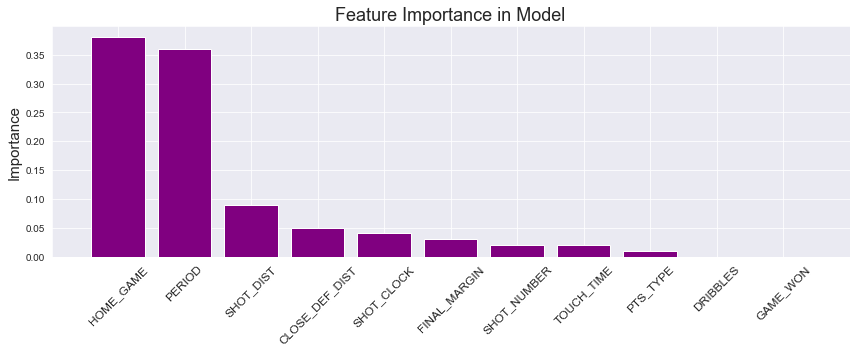

In [61]:
plot_feat_imp(ab_clf, data=features, color='purple')

#### 10 FOLD CROSS VALIDATION MODELING METRICS FOR ADABOOST MODEL ALL FEATURES

In [62]:
# 10 fold Cross-validation 
#ab_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#ab_cv_results_a = cross_val_score(ab_clf, features, target, cv=ab_kf, scoring="accuracy",n_jobs=-1) 
#ab_cv_results_p = cross_val_score(ab_clf, features, target, cv=ab_kf, scoring="precision_weighted",n_jobs=-1)
#ab_cv_results_r = cross_val_score(ab_clf, features, target, cv=ab_kf, scoring="recall_weighted",n_jobs=-1)
#ab_cv_results_f = cross_val_score(ab_clf, features, target, cv=ab_kf, scoring="f1_weighted",n_jobs=-1)

In [63]:
ab_cv_a = [0.62353025, 0.62239008, 0.62410033, 0.62716454, 0.6194684 ,0.62310269, 0.62160621, 0.62616689, 0.62571266, 0.62357469]

In [64]:
ab_cv_p = [0.62744889, 0.6262296 , 0.62673568, 0.63060666, 0.62333461,0.62726928, 0.62446966, 0.62983484, 0.63027223, 0.62599202]

In [65]:
ab_cv_r = [0.62353025, 0.62239008, 0.62410033, 0.62716454, 0.6194684 ,0.62310269, 0.62160621, 0.62616689, 0.62571266, 0.62357469]

In [66]:
ab_cv_f = [0.62109771, 0.61986451, 0.62128665, 0.62475958, 0.61692447,0.61967356, 0.61934943, 0.62361096, 0.62270634, 0.62130081]

# 2.5 AdaBoost Model With Engineered Features

#### SET UP ADABOOST CLASSIFIER FOR ENGINEERED FEATURES

In [67]:
ab2_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=10)
ab2_clf.fit(x_train1, y_train1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=10)

In [68]:
ab_pred2 = ab2_clf.predict(x_test1)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX FOR ADABOOST MODEL ENGINEERED FEATURES

In [69]:
print(60*'-')
print('AB Model Engineered Features')
print(60*'-')
report_ab2 = classification_report(y_test1, ab_pred2)
print(report_ab2)
print(60*'-')

------------------------------------------------------------
AB Model Engineered Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.67      0.63     17526
           1       0.62      0.54      0.57     17556

    accuracy                           0.60     35082
   macro avg       0.60      0.60      0.60     35082
weighted avg       0.60      0.60      0.60     35082

------------------------------------------------------------


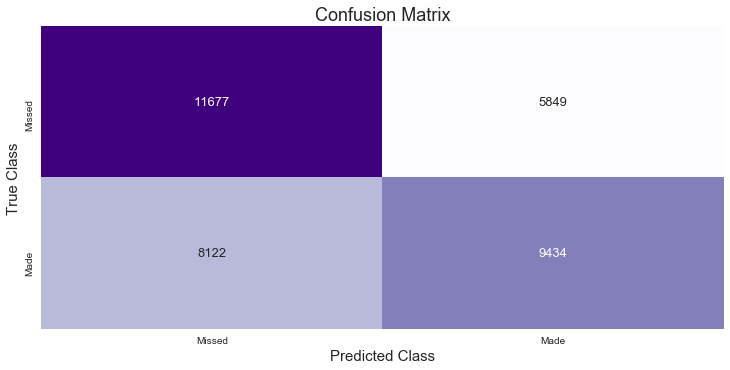

In [70]:
conf_matrix(y_test1, ab_pred2, cmap='Purples')

#### TRAIN AND TEST SCORES FOR ADABOOST MODEL ENGINEERED FEATURES

In [71]:
# Train and Test Scores For AB Model Engineered features
print("ADABOOST MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: {}".format(ab2_clf.score(x_train1, y_train1)))
print("ADABOOST MODEL ENGINEERED FEATURES FINAL TEST SCORES: {}".format(ab2_clf.score(x_test1, y_test1)))

ADABOOST MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: 0.5974858902001026
ADABOOST MODEL ENGINEERED FEATURES FINAL TEST SCORES: 0.6017615871387036


#### FEATURE IMPORTANCES ADABOOST MODEL ENGINEERED FEATURES

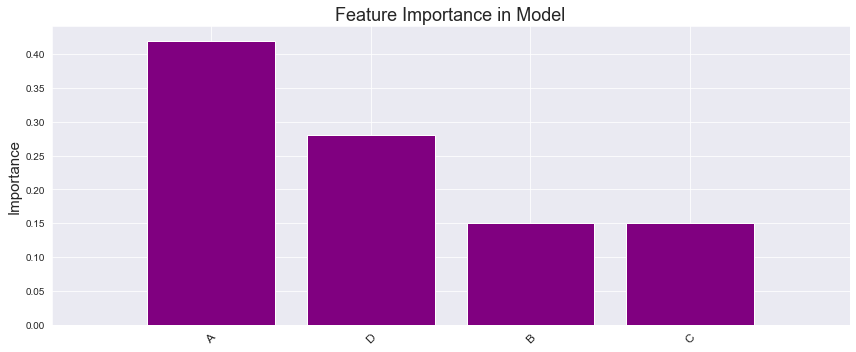

In [72]:
plot_feat_imp(ab2_clf, data=features2, color='purple')

#### 10 FOLD CROSS VALIDATION MODELING METRICS FOR ADABOOST MODEL ENGINEERED FEATURES

In [73]:
# 10 fold Cross-validation 
#ab2_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#ab2_cv_results_a = cross_val_score(ab2_clf, features2, target2, cv=ab2_kf, scoring="accuracy",n_jobs=-1) 
#ab2_cv_results_p = cross_val_score(ab2_clf, features2, target2, cv=ab2_kf, scoring="precision_weighted",n_jobs=-1)
#ab2_cv_results_r = cross_val_score(ab2_clf, features2, target2, cv=ab2_kf, scoring="recall_weighted",n_jobs=-1)
#ab2_cv_results_f = cross_val_score(ab2_clf, features2, target2, cv=ab2_kf, scoring="f1_weighted",n_jobs=-1)

In [74]:
ab2_cv_a = [0.60051308, 0.59801896, 0.59766265, 0.59809022, 0.59438466,0.59637996, 0.59459845, 0.60115442, 0.59570981, 0.59670753]

In [75]:
ab2_cv_p = [0.60294383, 0.6002882 , 0.59837489, 0.60050124, 0.59636954,0.59809794, 0.59611475, 0.60254523, 0.59797494, 0.59759144]

In [76]:
ab2_cv_r = [0.60051308, 0.59801896, 0.59766265, 0.59809022, 0.59438466,0.59637996, 0.59459845, 0.60115442, 0.59570981, 0.59670753]

In [77]:
ab2_cv_f = [0.59866089, 0.59612964, 0.59616981, 0.59575118, 0.59275589,0.5942895 , 0.59291842, 0.59988826, 0.59368087, 0.59534624]

# 2.6 Gradient Boosting Classifier
- This is a more powerful model
- We will set up a basline model with all features
- We then perform a Grid Search to identify the best parameters and optimize our model.
- We will then use this model with optimized parameters for the data with all features and the engineered features

#### BASELINE GB MODEL USING ALL FEATURES

In [78]:
gb_clf = GradientBoostingClassifier(random_state=10)
gb_clf.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [79]:
gb_pred = gb_clf.predict(x_test)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX FOR GB MODEL ALL FEATURES

In [80]:
print(60*'-')
print('GB Baseline Model All Features')
print(60*'-')
report_gb = classification_report(y_test, gb_pred)
print(report_gb)
print(60*'-')

------------------------------------------------------------
GB Baseline Model All Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.81      0.70     17526
           1       0.72      0.48      0.58     17556

    accuracy                           0.65     35082
   macro avg       0.67      0.65      0.64     35082
weighted avg       0.67      0.65      0.64     35082

------------------------------------------------------------


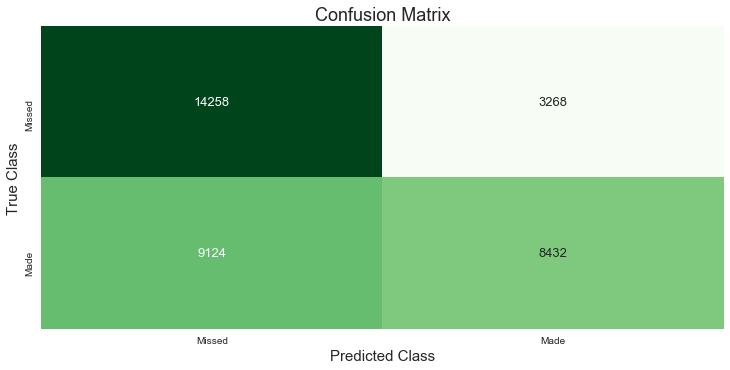

In [81]:
conf_matrix(y_test, gb_pred, cmap='Greens')

#### TRAIN AND TEST SCORES FOR INITIAL GB MODEL

In [82]:
# Train and Test Scores For Baseline GB Model all features
print("BASELINE GB MODEL ALL FEATURES FINAL TRAIN SCORES: {}".format(gb_clf.score(x_train, y_train)))
print("BASELINE GB MODEL ALL FEATURES FINAL TEST SCORES: {}".format(gb_clf.score(x_test, y_test)))

BASELINE GB MODEL ALL FEATURES FINAL TRAIN SCORES: 0.6477300800030404
BASELINE GB MODEL ALL FEATURES FINAL TEST SCORES: 0.6467704235790434


#### LOOK AT FEATURE IMPORTANCES FOR FIRST GB MODEL

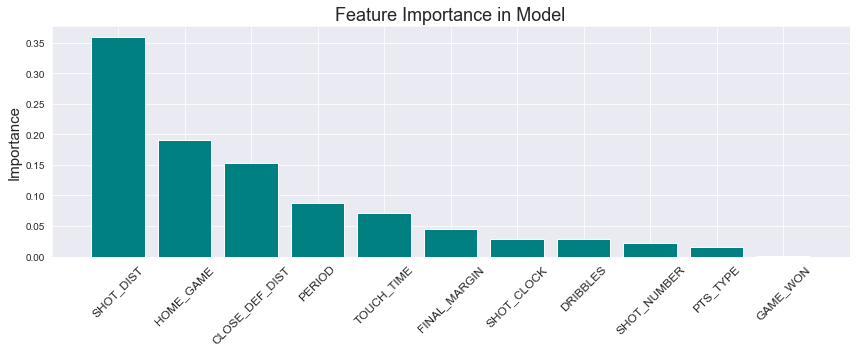

In [83]:
plot_feat_imp(gb_clf, data=features, color='teal')

#### 10 FOLD CROSS VALIDATION BASELINE GB MODEL ALL FEATURES

In [84]:
# 10 fold Cross-validation 
#gb_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#gb_cv_results_a = cross_val_score(gb_clf, features, target, cv=gb_kf, scoring="accuracy",n_jobs=-1) 
#gb_cv_results_p = cross_val_score(gb_clf, features, target, cv=gb_kf, scoring="precision_weighted",n_jobs=-1)
#gb_cv_results_r = cross_val_score(gb_clf, features, target, cv=gb_kf, scoring="recall_weighted",n_jobs=-1)
#gb_cv_results_f = cross_val_score(gb_clf, features, target, cv=gb_kf, scoring="f1_weighted",n_jobs=-1)

In [85]:
gb_cv_a = [0.64248557, 0.64512221, 0.64590608, 0.64811516, 0.64184422,0.64341196, 0.64227179, 0.64348322, 0.64566705, 0.64310148]

In [86]:
gb_cv_p = [0.65991654, 0.66447948, 0.66084838, 0.66430189, 0.65986053,0.66133322, 0.65758508, 0.65857771, 0.66507688, 0.65945401]

In [87]:
gb_cv_r = [0.64248557, 0.64512221, 0.64590608, 0.64811516, 0.64184422,0.64341196, 0.64227179, 0.64348322, 0.64566705, 0.64310148]

In [88]:
gb_cv_f = [0.63324049, 0.63495118, 0.636146  , 0.63933657, 0.63217583, 0.63275859, 0.63325258, 0.63495206, 0.63538673, 0.63288476]

#### SET UP GRID SEARCH TO FIND OPTIMIZED PARAMETERS

In [89]:
# Create a parameter grid: map the parameter names to the values that should be searched
#param_grid = {'learning_rate' : [0.1],
               #'max_depth' : range(5,10),
               #'max_features' : range(4,9),
               #'min_samples_leaf' : range(1,4),
               #'min_samples_split' : range(2,5),
               #'n_estimators' : [30,50,100]}
             

#Instantiate the grid
#grid = GridSearchCV(gb_clf, param_grid, cv=5, scoring='f1_macro', verbose=True, n_jobs=-1)

# fit the grid with data
#grid.fit(x_train, y_train)

In [90]:
# examine the best model

# Single best score achieved across all params 
#print(grid.best_score_)

# Dictionary containing the parameters used to generate that score
#print(grid.best_params_)


In [91]:
gb_params = {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
gb_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

# 2.7 Gradient Boosting Classifier with Optimized Parameters

#### FIT GRADIENT BOOSTING CLASSIFIER WITH OPTIMIZED PARAMETERS

In [92]:
# Use Gradient Boosting Classifier with Optimized parameters
gb2_clf = GradientBoostingClassifier(n_estimators=30, max_depth=6, random_state=10, max_features=8, learning_rate=0.10)
gb2_clf.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [93]:
gb2_pred = gb2_clf.predict(x_test)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX GRADIENT BOOSTING CLASSIFIER WITH OPTIMIZED PARAMETERS

In [94]:
print(60*'-')
print('GB Model Optimized Parameters')
print(60*'-')
report2_gb = classification_report(y_test, gb2_pred)
print(report2_gb)
print(60*'-')

------------------------------------------------------------
GB Model Optimized Parameters
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.81      0.69     17526
           1       0.71      0.47      0.57     17556

    accuracy                           0.64     35082
   macro avg       0.66      0.64      0.63     35082
weighted avg       0.66      0.64      0.63     35082

------------------------------------------------------------


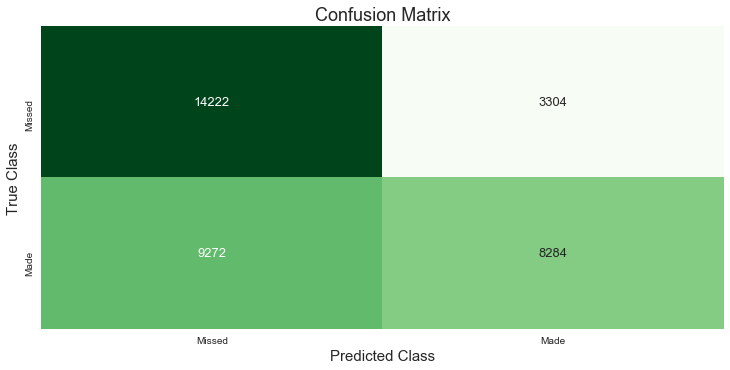

In [95]:
conf_matrix(y_test, gb2_pred, cmap='Greens')

#### TRAIN AND TEST SCORES FOR OPTIMIZED GB MODEL

In [96]:
# Train and Test Scores For Optimized GB Model
print("OPTIMIZED GB MODEL FINAL TRAIN SCORES: {}".format(gb2_clf.score(x_train, y_train)))
print("OPTIMIZED GB MODEL FINAL TEST SCORES: {}".format(gb2_clf.score(x_test, y_test)))

OPTIMIZED GB MODEL FINAL TRAIN SCORES: 0.6454592098512058
OPTIMIZED GB MODEL FINAL TEST SCORES: 0.6415255686676928


#### LOOK AT FEATURE IMPORTANCES FOR OPTIMIZED GB MODEL

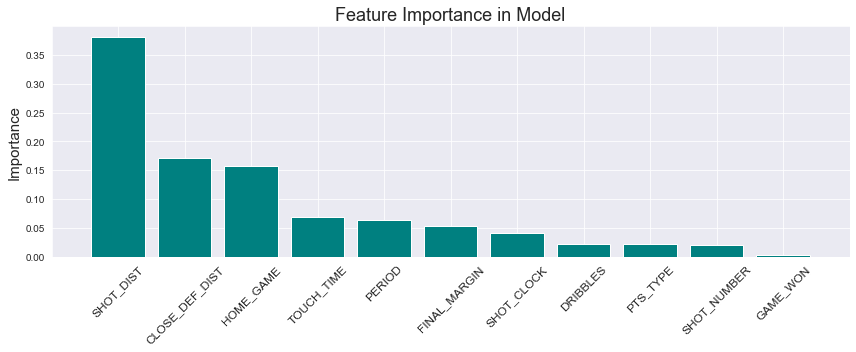

In [97]:
plot_feat_imp(gb2_clf, data=features, color='teal')

#### TEN FOLD CROSS VALIDATION OPTIMIZED GB MODEL

In [98]:
# 10 fold Cross-validation 
#gb2_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#gb2_cv_results_a = cross_val_score(gb2_clf, features, target, cv=gb2_kf, scoring="accuracy",n_jobs=-1) 
#gb2_cv_results_p = cross_val_score(gb2_clf, features, target, cv=gb2_kf, scoring="precision_weighted",n_jobs=-1)
#gb2_cv_results_r = cross_val_score(gb2_clf, features, target, cv=gb2_kf, scoring="recall_weighted",n_jobs=-1)
#gb2_cv_results_f = cross_val_score(gb2_clf, features, target, cv=gb2_kf, scoring="f1_weighted",n_jobs=-1)

In [99]:
gb2_cv_a = [0.63835245, 0.63992019, 0.64241431, 0.64462339, 0.63842372,0.64106036, 0.63457564, 0.64127414, 0.64089225, 0.63732896]

In [100]:
gb2_cv_p = [0.65524519, 0.66081168, 0.65721253, 0.6621263 , 0.65533842,0.65921023, 0.65001165, 0.65597372, 0.6591823 , 0.65292616]

In [101]:
gb2_cv_r = [0.63835245, 0.63992019, 0.64241431, 0.64462339, 0.63842372,0.64106036, 0.63457564, 0.64127414, 0.64089225, 0.63732896]

In [102]:
gb2_cv_f = [0.62903488, 0.62847234, 0.63240717, 0.63488059, 0.62902904, 0.63004797, 0.6248041 , 0.63277999, 0.63073536, 0.62697438]

# 2.8 Gradient Boosting Classifier with Engineered Features

#### FIT GB MODEL WITH ENGINEERED FEATURES

In [103]:
# Use Gradient Boosting Classifier with Optimized parameters and Engineered Features
gb3_clf = GradientBoostingClassifier(n_estimators=30, max_depth=6, random_state=10, max_features=4, learning_rate=0.10)
gb3_clf.fit(x_train1, y_train1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [104]:
gb3_pred = gb3_clf.predict(x_test1)

#### CLASSIFICATION REPORT AND CONFUSION MATRIX GB MODEL ENGINEERED FEATURES

In [105]:
print(60*'-')
print('GB Model Optimized Parameters and Engineered Features')
print(60*'-')
report3_gb = classification_report(y_test1, gb3_pred)
print(report3_gb)
print(60*'-')

------------------------------------------------------------
GB Model Optimized Parameters and Engineered Features
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.75      0.66     17526
           1       0.65      0.47      0.55     17556

    accuracy                           0.61     35082
   macro avg       0.62      0.61      0.60     35082
weighted avg       0.62      0.61      0.60     35082

------------------------------------------------------------


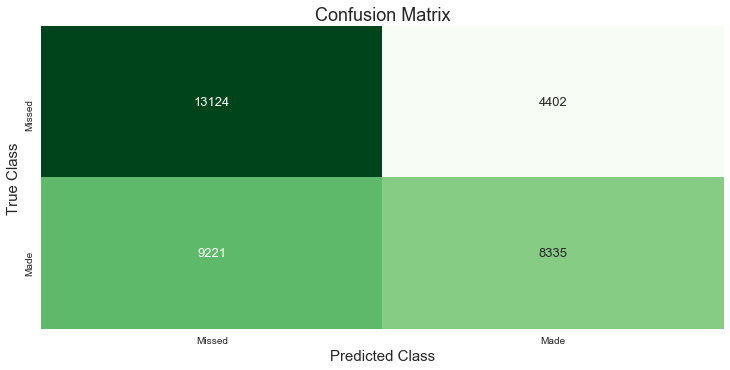

In [106]:
conf_matrix(y_test1, gb3_pred, cmap="Greens")

#### TRAIN AND TEST SCORES GB MODEL WITH ENGINEERED FEATURES

In [107]:
# Train and Test Scores For GB Model with Engineered Features
print("GB MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: {}".format(gb3_clf.score(x_train1, y_train1)))
print("GB MODEL ENGINEERED FEATURES FINAL TEST SCORES: {}".format(gb3_clf.score(x_test1, y_test1)))

GB MODEL ENGINEERED FEATURES FINAL TRAIN SCORES: 0.6146456872470213
GB MODEL ENGINEERED FEATURES FINAL TEST SCORES: 0.6116812040362579


#### FEATURE IMPORTANCES GB MODEL ENGINEERED FEATURES

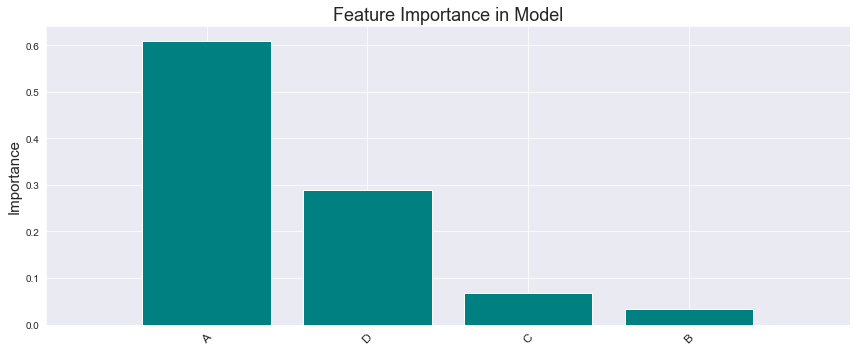

In [108]:
plot_feat_imp(gb3_clf, data=features2, color='teal')

#### 10 FOLD CROSS VALIDATION GB MODEL ENGINEERED FEATURES

In [109]:
# 10 fold Cross-validation 
#gb3_kf = KFold(n_splits=10, shuffle=True, random_state=10)
#gb3_cv_results_a = cross_val_score(gb3_clf, features2, target2, cv=gb3_kf, scoring="accuracy",n_jobs=-1) 
#gb3_cv_results_p = cross_val_score(gb3_clf, features2, target2, cv=gb3_kf, scoring="precision_weighted",n_jobs=-1)
#gb3_cv_results_r = cross_val_score(gb3_clf, features2, target2, cv=gb3_kf, scoring="recall_weighted",n_jobs=-1)
#gb3_cv_results_f = cross_val_score(gb3_clf, features2, target2, cv=gb3_kf, scoring="f1_weighted",n_jobs=-1)

In [110]:
gb3_cv_a = [0.61013326, 0.61341124, 0.61105965, 0.61141595, 0.60585762,0.60692653, 0.60685527, 0.60913561, 0.60711231, 0.61181585]

In [111]:
gb3_cv_p = [0.61942858, 0.62316855, 0.61704483, 0.61869183, 0.61398299,0.61365242, 0.61245652, 0.61426594, 0.61591141, 0.61769236]

In [112]:
gb3_cv_r = [0.61013326, 0.61341124, 0.61105965, 0.61141595, 0.60585762,0.60692653, 0.60685527, 0.60913561, 0.60711231, 0.61181585]

In [113]:
gb3_cv_f = [0.60326605, 0.60624117, 0.60458181, 0.60548649, 0.59949717,0.6005301 , 0.60178429, 0.60485033, 0.60002858, 0.6061086]

# 2.9 Visually Compare Models 10-Fold Cross Validation Metrics

#### DEFINE VARIABLES. BUILD FUNCTION FOR PLOTS

In [114]:
# Define Variables for Plot
res = [rf_cv_a, rf2_cv_a, ab_cv_a, ab2_cv_a, gb_cv_a, gb2_cv_a, gb3_cv_a]
names = ['RForest', 'RForest_EF', 'AdaBoost', 'AdaBoost_EF', 'GBoost', 'GBoost_Opt', 'GBoost_Opt_EF']

In [115]:
# Function for plotting the 10 fold cross validated scores for Models
def cv_plot(names=names, res=res, a='Accuracy'):
    plt.figure(figsize=(18,6))
    sns.set(font_scale=1.5)
    sns.boxplot(x=names, y=res, notch=True)
    plt.title('10-Fold CV {} '.format(a), fontsize=18)
    plt.ylabel('{}'.format(a), fontsize= 17)
    plt.show()

#### ACCURACY

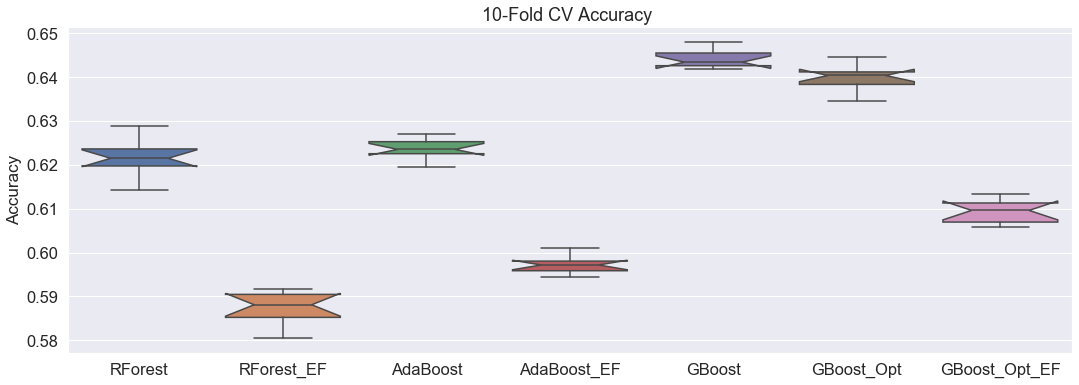

In [116]:
cv_plot()

#### PRECISION

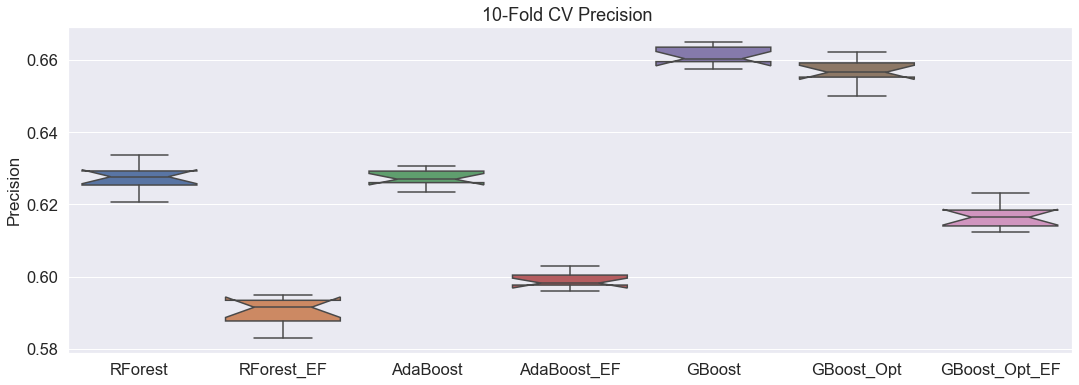

In [117]:
res2 = [rf_cv_p, rf2_cv_p, ab_cv_p, ab2_cv_p, gb_cv_p, gb2_cv_p, gb3_cv_p]
cv_plot(names=names, res=res2, a='Precision')

#### F1-SCORE

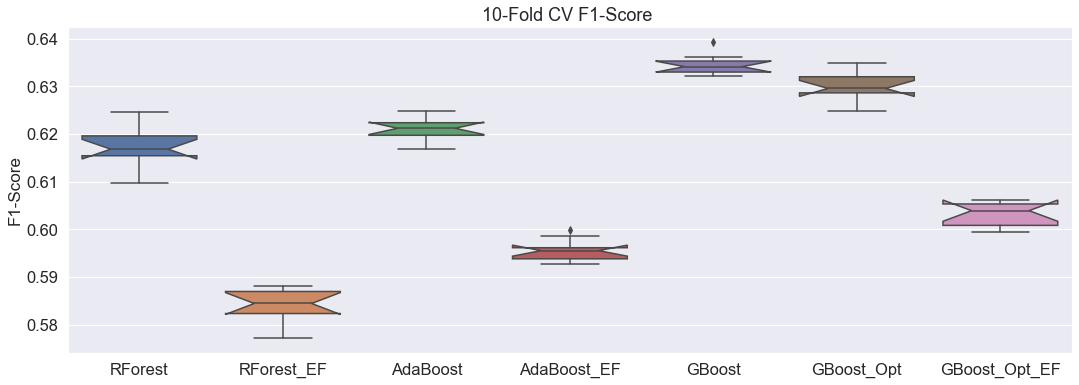

In [118]:
res3 = [rf_cv_f, rf2_cv_f, ab_cv_f, ab2_cv_f, gb_cv_f, gb2_cv_f, gb3_cv_f]
cv_plot(names=names, res=res3, a='F1-Score')

#### RECALL

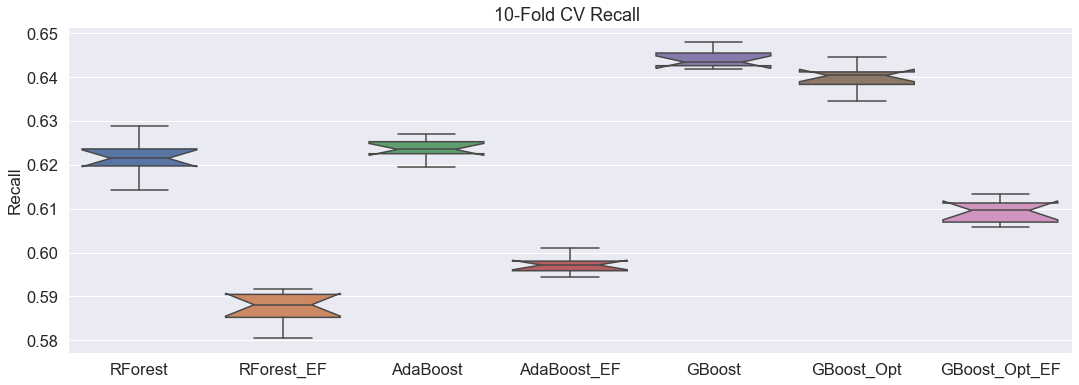

In [119]:
res4 = [rf_cv_r, rf2_cv_r, ab_cv_r, ab2_cv_r, gb_cv_r, gb2_cv_r, gb3_cv_r]
cv_plot(names=names, res=res4, a='Recall')

# 2.10 Conclusions: What is Our Best Model?
- To answer this question let’s start with what we know from our previous analysis.
- The overall shooting percentage in the NBA for the 2014-2015 season was 45%.
- This gives us the ground truth values that we would like to improve upon with our models.
- 55% of all shots taken were missed (class 0 in our models).
- 45% of all shots taken were made (class 1 in our models).
- Looking at the graphs of the 10-fold validation metrics it is clear the gradient boosting model performs the best.  Right?
- Yes and No.  The gradient boosting model classifies or “predicts” missed shots correctly 81% of the time. A 26% increase above the actual value.  55% of all shots were missed during this season.  This gives us valuable and useful information.  With this model, and the feature importances associated with the model, we have insight into what constitutes a “bad” shot or a shot that is likely to be missed. For instance, shot distance and closest defender were important features in this model.  Passing the ball to a player who is closer to the basket and less closely defended will likely improve the chances of making the shot.
- However, the gradient boosting model only classified made shots correctly at 48%. Just 3% above the actual value of 45% of all shots made during this season.
- It was clear from initial analysis that made shots would be the more difficult class to classify.
- I intentionally included the AdaBoost model with a decision tree base estimator.  This model focuses more on the harder to classify examples.
- With the AdaBoost model we were able to correctly classify missed shots 71% of the time.  However, we improved the classification of made shots to 54%.  And feature importances shifted.  Home game and the period the shot was taken became the most important features.  Shot distance and closest defender were still important.  Having these two added dimensions gives a better idea of what constitutes a “good” shot with a better chance of going in.
- This is a case where one model outperforms the other in classifying a particular class.  We don’t have to choose.  Each model provides important information and should be used in combination.


# 2.11 Future Directions
- We only have one season of data.  Data from multiple seasons would be helpful for statistical analysis as well as building more robust models.
- To improve our model for classifying game outcome we should add more statistics that are important in determining the outcome of the game.  Rebounds, free throws, steals, turnovers and points off turnovers are all stats that are generally skewed in the winner or losers favor.  A Team that has more rebounds (especially offensive rebounds), more steals, less turnovers and more free throws will be much more likely to win the game.  This information was not available in our data set.
- In this data set we were only given shot distance.  It would be helpful to have the shot coordinates.  Where the shot was taken on the floor.  A corner 3-pointer is only 20 feet from the basket and is therefore a higher percentage shot.  A 3-point shot in front of the basket is 23.75 feet and not surprisingly a lower percentage shot.  It would have been interesting to see the shot groupings by actual position on the court.


# THANK YOU!